# Image Manipulation with generative K-Means Auto Encoder
## MTHM038 - Dissertation Project  Code

GitHub: https://github.com/KasiChennupati/Image-Manipulation-with-Generative-K-Means-Autoencoders
<br>
GoogleDrive : https://drive.google.com/file/d/1tmUnVripcLc0GPaUQcNKjIIdVHoUkxVK/view?usp=sharing

The trained model and the pickle files of the centroids, full training encoded data and full testing encoded data are zipped and uploaded to the google drive link above.<br>
All the Code files are also uploaded to the above github repository.

## Imports

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px

import pickle

import sys
import datetime
# import os
# import time
from subprocess import call
import warnings

warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda import device_count, current_device
from torch.backends.cudnn import version
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
import torch.nn.functional as fct
import torchvision


print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('\n__CUDA VERSION', )
call(["nvcc", "--version"])
! nvcc --version
print('\n__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)
print("Torch.device set to -->",dev)

__Python VERSION: 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
__pyTorch VERSION: 1.8.1+cu111

__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Tue_Sep_15_19:12:04_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.1, V11.1.74
Build cuda_11.1.relgpu_drvr455TC455_06.29069683_0

__CUDNN VERSION: 8005
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
Torch.device set to --> cuda:0


## Auto Encoder Architecture

In [190]:
class AE(nn.Module):
    def __init__(self):
        # N, 784(28*28)
        super(AE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*28 * 28, 1700),
            nn.ReLU(),
            nn.Linear(1700, 1100),
            nn.ReLU(),
            nn.Linear(1100,512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()

        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1100),
            nn.ReLU(),
            nn.Linear(1100, 1700),
            nn.ReLU(),
            nn.Linear(1700, 3*28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

model = AE()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
model.zero_grad()
print(summary(model, input_size=(1,3* 28* 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1700]       4,000,100
              ReLU-2              [-1, 1, 1700]               0
            Linear-3              [-1, 1, 1100]       1,871,100
              ReLU-4              [-1, 1, 1100]               0
            Linear-5               [-1, 1, 512]         563,712
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              ReLU-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 512]         131,584
             ReLU-10               [-1, 1, 512]               0
           Linear-11              [-1, 1, 1100]         564,300
             ReLU-12              [-1, 1, 1100]               0
           Linear-13              [-1, 1, 1700]       1,871,700
             ReLU-14              [-1, 

In [191]:

model.load_state_dict(torch.load('load_binaries/model.pth'))
#optimizer.load_state_dict(torch.load('load_binaries/optimizer_col.pth'))

with open('load_binaries/mnistdigits_training_data_v3.pkl', 'rb') as f:
    mnistdigits_training_data = pickle.load(f)

with open('load_binaries/mnistdigits_testing_data_v3.pkl', 'rb') as f:
    mnistdigits_testing_data = pickle.load(f)

with open('load_binaries/outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

with open('load_binaries/col_centroids.pkl', 'rb') as f:
    col_centroids = pickle.load(f)
    

In [192]:
model.eval

<bound method Module.eval of AE(
  (encoder): Sequential(
    (0): Linear(in_features=2352, out_features=1700, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1700, out_features=1100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1100, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1100, out_features=1700, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1700, out_features=2352, bias=True)
    (7): Sigmoid()
  )
)>

In [193]:
MNIST_train_images_rgb = mnistdigits_training_data["images_rgb"]
MNIST_train_images_gray = mnistdigits_training_data["images_gray"]
MNIST_train_digits = mnistdigits_training_data["digits"]
MNIST_train_colors = mnistdigits_training_data["colors"]
MNIST_train_total_categories = mnistdigits_training_data["total_categories"]
MNIST_training_batch_size = 300
MNIST_train_dataset =TensorDataset(MNIST_train_images_rgb, MNIST_train_digits, MNIST_train_colors, MNIST_train_images_gray, MNIST_train_total_categories)
MNIST_train_dataloader = DataLoader(MNIST_train_dataset, batch_size=MNIST_training_batch_size, shuffle = True)

MNIST_test_images_rgb = mnistdigits_testing_data["images_rgb"]
MNIST_test_images_gray = mnistdigits_testing_data["images_gray"]
MNIST_test_digits = mnistdigits_testing_data["digits"]
MNIST_test_colors = mnistdigits_testing_data["colors"]
MNIST_test_total_categories = mnistdigits_testing_data["total_categories"]
MNIST_test_batch_size = 300
MNIST_test_dataset =TensorDataset(MNIST_test_images_rgb, MNIST_test_digits, MNIST_test_colors, MNIST_test_images_gray, MNIST_test_total_categories)
MNIST_test_dataloader = DataLoader(MNIST_test_dataset, batch_size=MNIST_test_batch_size, shuffle = True)

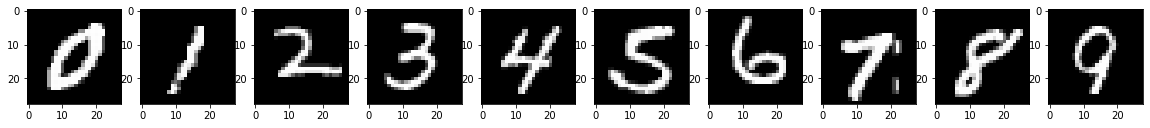

In [194]:
plt.figure(figsize=(20,5))

for i in range(10):
    index = mnistdigits_training_data["digits"].tolist().index(i)
    plt.subplot(1, 10, i+1)
    plt.imshow(mnistdigits_training_data["images_gray"][index].detach().reshape(1,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
plt.show()

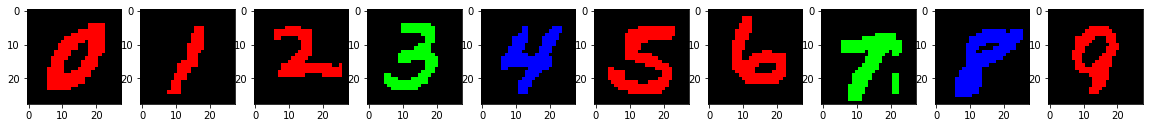

In [195]:
plt.figure(figsize=(20,5))

for i in range(10):
    index = mnistdigits_training_data["digits"].tolist().index(i)
    plt.subplot(1, 10, i+1)
    plt.imshow(mnistdigits_training_data["images_rgb"][index].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
plt.show()

## K Means Clustering Functions

In [11]:
def cluster_fc(data,n_clusters,centroids=None, maximum_counter = 300, tolerance = 1e-9,device = "cpu"):
    distances = torch.cdist(data.to(device), centroids.to(device))
    assignments = torch.zeros((data.shape[0], n_clusters))
    assignments[torch.arange(data.shape[0]), torch.argmin(distances, dim=1)] = 1
    predictions = torch.argmax(assignments, dim=1)  # converts one-hot to cluster based
    return predictions

In [9]:
def kmeans_clustering(data, n_clusters, centroids, labels, maximum_counter=300, tolerance=1e-9, device="cpu"):
    data = data.view(data.shape[0], data.shape[-1]).to(device)
    energy = torch.tensor([float('inf')])
    counter = 0
    labels = labels.to(device)
    sensitivity = torch.tensor([float('inf')])
    print_output = 50
    data = data.to(device)

    if type(centroids).__name__ != "Tensor":
        centroids = torch.randn(n_clusters, data.shape[-1], device=device)
    else:
        centroids = centroids.to(device)
    while (counter < maximum_counter) and (sensitivity > tolerance):
        previous_energy = energy
        distances = torch.cdist(data, centroids)
        assignments = torch.zeros((data.shape[0], n_clusters), device=device, dtype= torch.float32)
        assignments[torch.arange(data.shape[0]), torch.argmin(distances, dim=1)] = 1
        predictions = torch.argmax(assignments, dim=1)
        denominator = torch.Tensor.repeat(torch.sum(assignments.cpu(), dim=0), data.shape[1], 1).T.to(device)
        centroids = (assignments.T @ data) / denominator
        centroids[denominator == 0] = 0
        distances_min = torch.Tensor(torch.min(distances.cpu() ** 2, 1)[0])
        energy = torch.sum(distances_min)
        sensitivity = (previous_energy - energy) / energy
        counter += 1
    return predictions,centroids

In [ ]:
init_time = datetime.datetime.now()
# ----------------------------------------------------------------------------
torch.autograd.set_detect_anomaly(True)
epochs = 30
counter_print = 60000/600
maximum_counter = 300
num_tolerance=1e-9
col_tolerance=1e-9 
outputs =[]
n_clusters = 3
col_clusters = 3
epochloss = 0
accuracy = 0
lambda_1 = 0.9
lambda_2 = 1
lambda_3 = 0 #.09

num_maximum_counter = 300

model.zero_grad()
acc = 0
epochenergy = 0

for epoch in range(epochs):
    counter = 1
    old_acc = acc
    previous_epochenergy = epochenergy
    epochloss = 0
    epoch_loss1 =0
    epoch_loss2 = 0
    for sample in enumerate(MNIST_train_dataloader):
        image = sample[1][0].to(device)
        num_labels = sample[1][1]
        col_labels = sample[1][2]
        encoded, decoded = model(image.view(-1, 3*28*28))
        decoded = decoded.view(-1,3,28,28)
        z = fct.one_hot(col_labels, num_classes=n_clusters).to(device, dtype= torch.float32)
        encoded_copy = encoded
        if epoch ==0 and counter==1: 
            new_centroids = cluster_fa(encoded_copy, n_clusters=n_clusters, labels = col_labels, device=device)
            dist_matrix = z @ new_centroids.to(device)
        else:
            dist_matrix = z @ new_centroids.to(device)
        loss1 = 1.6*criterion(decoded, image)
        loss2 = criterion(encoded, dist_matrix.detach())
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epochloss +=loss.item()
        epoch_loss1 +=loss1.item()
        epoch_loss2 +=loss2.item()
        counter +=1
    
    epochloss = epochloss/(counter-1)
    epoch_loss1 = epoch_loss1/(counter-1)
    epoch_loss2 = epoch_loss2/(counter-1)

    data = encoded 
    knum_labels = col_labels
    num_centroids = new_centroids
    num_counter = 1
    num_energy = torch.tensor([float('inf')])
    num_sensitivity = torch.tensor([float('inf')])

    while (num_counter < num_maximum_counter) and (num_sensitivity > num_tolerance):
        num_previous_energy = num_energy
        num_distances = torch.cdist(data.to(device), num_centroids.to(device))
        num_assignments = torch.zeros((data.shape[0], n_clusters)).to(device)
        num_assignments[torch.arange(data.shape[0]), torch.argmin(num_distances, dim=1)] = 1
        num_predictions = torch.argmax(num_assignments, dim=1) # converts one-hot to cluster based
        num_denominator = torch.Tensor.repeat(torch.sum(num_assignments, dim=0), data.shape[1], 1).T.to(device)
        num_centroids = (num_assignments.T @ data) / num_denominator
        num_centroids[num_denominator == 0] = 0
        num_distances_min = torch.Tensor(torch.min(num_distances.cpu() ** 2, 1)[0])
        num_centroid_dist = torch.cdist(num_centroids, num_centroids)**2
        num_energy = torch.sum(num_distances_min).cpu()
        num_sensitivity = (num_previous_energy - num_energy).cpu() / num_energy.cpu()
        num_counter += 1
    
    NMI_Score = metrics.normalized_mutual_info_score(col_labels.cpu(), num_predictions.cpu())
    ARS = metrics.adjusted_rand_score(col_labels.cpu(), num_predictions.cpu())
    new_centroids = num_centroids

    epochenergy = loss/torch.sum(num_centroid_dist)

    epochsensitivity = (previous_epochenergy - epochenergy)/ epochenergy
    print(f'\nEpoch:{epoch + 1}, Loss:{epochloss:.6f},loss2: {loss2:.6f}, Epochenergy:{epochenergy:.5f}, NMI_Score:{NMI_Score*100:.2f}, ARS:{ARS*100:.2f}, sensitivity:{epochsensitivity}')
    outputs.append(dict(
                        {
                         "epoch": epoch,                              "epochloss": epochloss,
                         "epoch_loss1": epoch_loss1,                  "epoch_loss2":epoch_loss2,
                          "epoch_energy":epochenergy,                        
                          "image": image.cpu(),
                          "encoded": encoded.cpu(),                    "decoded": decoded.cpu(),
                          "labels": num_labels.cpu(),                      "color_labels": col_labels.cpu(),
                         "centroids":new_centroids.cpu(),
                         "NMI_Score": round(NMI_Score*100,4), "ARS_Score":round(ARS*100,4)
                         }
                     )
                 )
# ------------------------------------------------------------------------------
fin_time = datetime.datetime.now()
print("\n\nExecution time: ", (fin_time-init_time))

## Performance Evaluation on the training Data Set

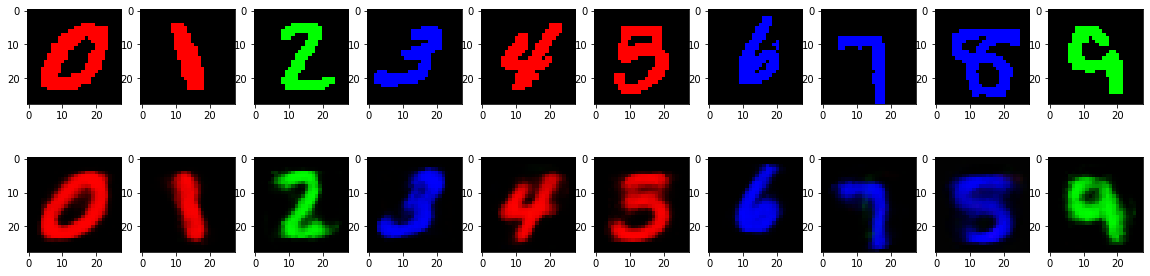

In [10]:
plt.figure(figsize=(20,5))
epoch = -1
for i in range(10):

    index = outputs[epoch]["labels"].tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(outputs[epoch]["image"][index].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(outputs[epoch]["decoded"][index].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
    
plt.show()

In [12]:
with torch.no_grad(): 
    full_col_encoded = model.encoder(MNIST_train_images_rgb.view(-1,3*28*28).to(device)).cpu()

full_train_predictions = cluster_fc(full_col_encoded, n_clusters = 3, centroids=col_centroids.cpu(), maximum_counter=300, tolerance=1e-9, device="cpu")

In [13]:
NMI_Score = metrics.normalized_mutual_info_score(MNIST_train_colors.cpu(), full_train_predictions.cpu())
ARS = metrics.adjusted_rand_score(MNIST_train_colors.cpu(), full_train_predictions.cpu())
print(NMI_Score)
print(ARS)

0.9954404519799954
0.9980597998658112


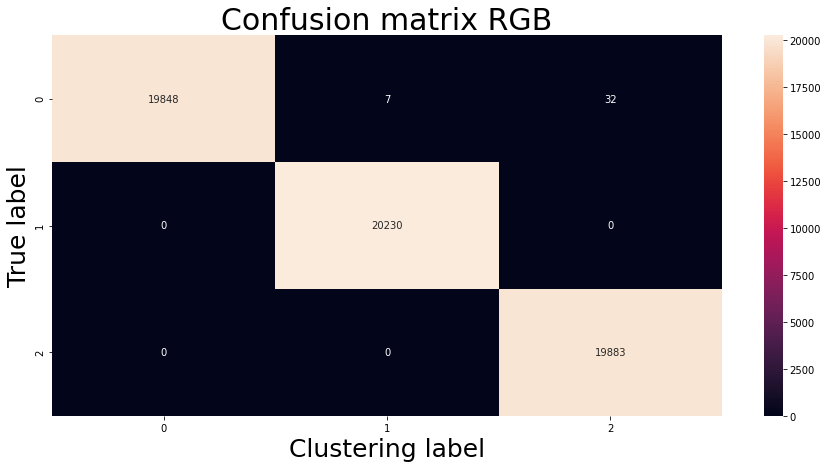

In [14]:
cm_col = confusion_matrix(MNIST_train_colors.cpu(), full_train_predictions.cpu())
plt.figure(figsize=(15, 7))
sns.heatmap(cm_col, annot=True, fmt="d")
plt.title("Clustering Confusion matrix RGB-Training", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [15]:
train_cls_report = classification_report(MNIST_train_colors.cpu(), full_train_predictions.cpu())
print(train_cls_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19887
           1       1.00      1.00      1.00     20230
           2       1.00      1.00      1.00     19883

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



In [25]:
x, y, z = torch.pca_lowrank(full_col_encoded.detach(), q=2, center=True)

df1 = pd.DataFrame(x, columns=["X","Y"])
df1["num_labels"] = MNIST_train_digits.cpu()
df1["col_labels"] = MNIST_train_colors.cpu()
df1["predictions"] = full_train_predictions.cpu()
df1.head()

cmap = [[1,0,0],[0,1,0],[0,0,1]]
# centroid = torch.pca_lowrank(col_centroids, q = 2)
# plt.figure(figsize=(10,5))
# plt.scatter(df1["X"],df1["Y"],marker='.', c =full_train_predictions.cpu(), cmap="rainbow")
# #plt.scatter(centroid[0][:])
# plt.title("")
# #plt.scatter()
# plt.show()


# fig.show()

,X,Y,num_labels,col_labels,predictions
0,tensor(6.8078e-05),tensor(-0.0079),0,0,0
1,tensor(-0.0008),tensor(-0.0024),9,0,0
2,tensor(-0.0048),tensor(0.0051),0,2,2
3,tensor(0.0079),tensor(0.0037),3,1,1
4,tensor(-0.0025),tensor(-0.0024),2,0,0


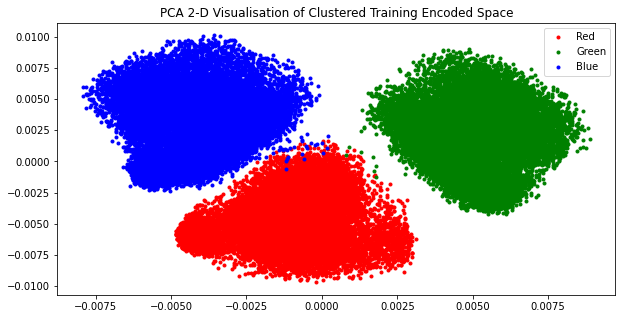

<Figure size 432x288 with 0 Axes>

In [30]:
colors_src = ['#ff0000','#00ff00','#0000ff']
color_list = []

for i in df1["predictions"]:
    color_list.append(colors_src[i])


df_red = df1[df1["predictions"] == 0]
df_green = df1[df1["predictions"] == 1]
df_blue = df1[df1["predictions"] == 2]

plt.figure(figsize=(10,5))
plt.scatter(df_red["X"],df_red["Y"],marker='.', c ='r', label = "Red")
plt.scatter(df_green["X"],df_green["Y"],marker='.', c ='g', label = "Green")
plt.scatter(df_blue["X"],df_blue["Y"],marker='.', c ='b', label = "Blue")
#plt.scatter(centroid[0][0].detach(),centroid[0][1].detach(), marker = '*', c = 'y')
plt.title("PCA 2-D Visualisation of Clustered Training Encoded Space")
plt.legend()
plt.show()

## Performance evaluation on Testing Dataset

In [31]:
with torch.no_grad(): 
    full_col_test_encoded = model.encoder(MNIST_test_images_rgb.view(-1,3*28*28).to(device)).cpu()

full_test_predictions = cluster_fc(full_col_test_encoded, n_clusters = 3, centroids=col_centroids.cpu(), maximum_counter=300, tolerance=1e-9, device="cpu")

In [32]:
NMI_Score = metrics.normalized_mutual_info_score(MNIST_test_colors.cpu(), full_test_predictions.cpu())
ARS = metrics.adjusted_rand_score(MNIST_test_colors.cpu(), full_test_predictions.cpu())
print(NMI_Score)
print(ARS)

0.9965864317201026
0.9985039376784578


In [197]:
test_cls_report = classification_report(MNIST_test_colors.cpu(), full_test_predictions.cpu())
print(test_cls_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3303
           1       1.00      1.00      1.00      3347
           2       1.00      1.00      1.00      3350

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



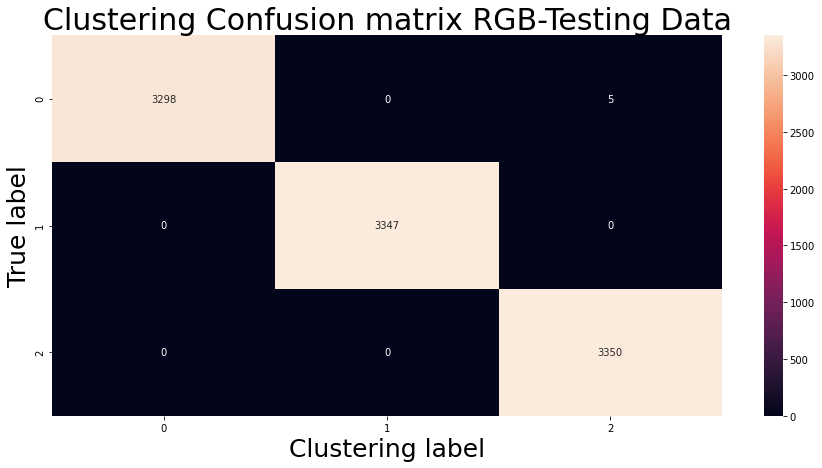

In [38]:
cm_col = confusion_matrix(MNIST_test_colors.cpu(), full_test_predictions.cpu())
plt.figure(figsize=(15, 7))
sns.heatmap(cm_col, annot=True, fmt="d")
plt.title("Clustering Confusion matrix RGB-Testing Data", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Function to Generate Random Samples from Encoded Data

In [123]:
 def generate_samples(data, centroids,color,n_samples, model, device="cpu"):
        preds = cluster_fc(data, n_clusters = 3, centroids=centroids.cpu(), maximum_counter=300, tolerance=1e-9, device="cpu")
        index = [preds== color]
        data = data[index]
        with torch.no_grad():
            data = model.decoder(data.to(device))
        index = range(data.shape[0])
        index = np.random.choice(index, n_samples)
        data = data[index].view(-1, 3,28,28).detach().cpu()
        
        return data

## Generating Random Samples from the Learned Data

In [126]:
red_random_sample = generate_samples(full_col_encoded, centroids = col_centroids.cpu(), color = 0, n_samples = 10, model = model, device=device)
green_random_sample = generate_samples(full_col_encoded, centroids = col_centroids.cpu(), color = 1, n_samples = 10, model = model, device=device)
blue_random_sample = generate_samples(full_col_encoded, centroids = col_centroids.cpu(), color = 2, n_samples = 10, model = model, device=device)

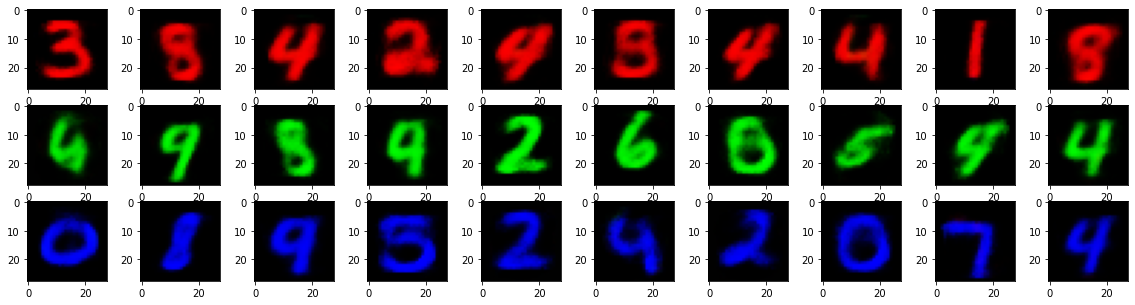

In [132]:
red_random_sample = generate_samples(full_col_encoded, centroids = col_centroids.cpu(), color = 0, n_samples = 10, model = model, device=device)
green_random_sample = generate_samples(full_col_encoded, centroids = col_centroids.cpu(), color = 1, n_samples = 10, model = model, device=device)
blue_random_sample = generate_samples(full_col_encoded, centroids = col_centroids.cpu(), color = 2, n_samples = 10, model = model, device=device)

plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(red_random_sample[i].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
    plt.subplot(3, 10, i+11)
    plt.imshow(green_random_sample[i].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
    plt.subplot(3, 10, i+21)
    plt.imshow(blue_random_sample[i].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()

plt.show()

## Encoder Signal Visualisation

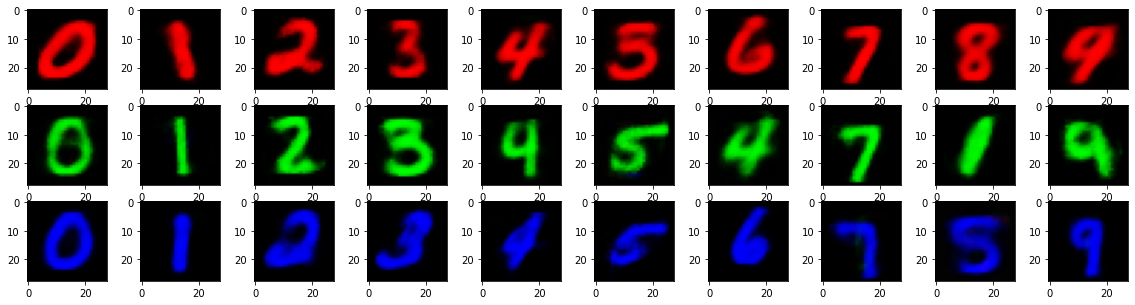

In [161]:
labels_30 = outputs[epoch]["color_labels"]*10 + outputs[epoch]["labels"]

plt.figure(figsize=(20,5))

for i in range(10):
    rindex = labels_30.tolist().index(i)
    gindex = labels_30.tolist().index(i+10)
    bindex = labels_30.tolist().index(i+20)
    plt.subplot(3, 10, i+1)
    plt.imshow(outputs[epoch]["decoded"][rindex].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
    plt.subplot(3, 10, i+11)
    plt.imshow(outputs[epoch]["decoded"][gindex].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()
    plt.subplot(3, 10, i+21)
    plt.imshow(outputs[epoch]["decoded"][bindex].detach().reshape(3,28,28).T.transpose(0,1).cpu().squeeze())
    plt.gray()

plt.show()


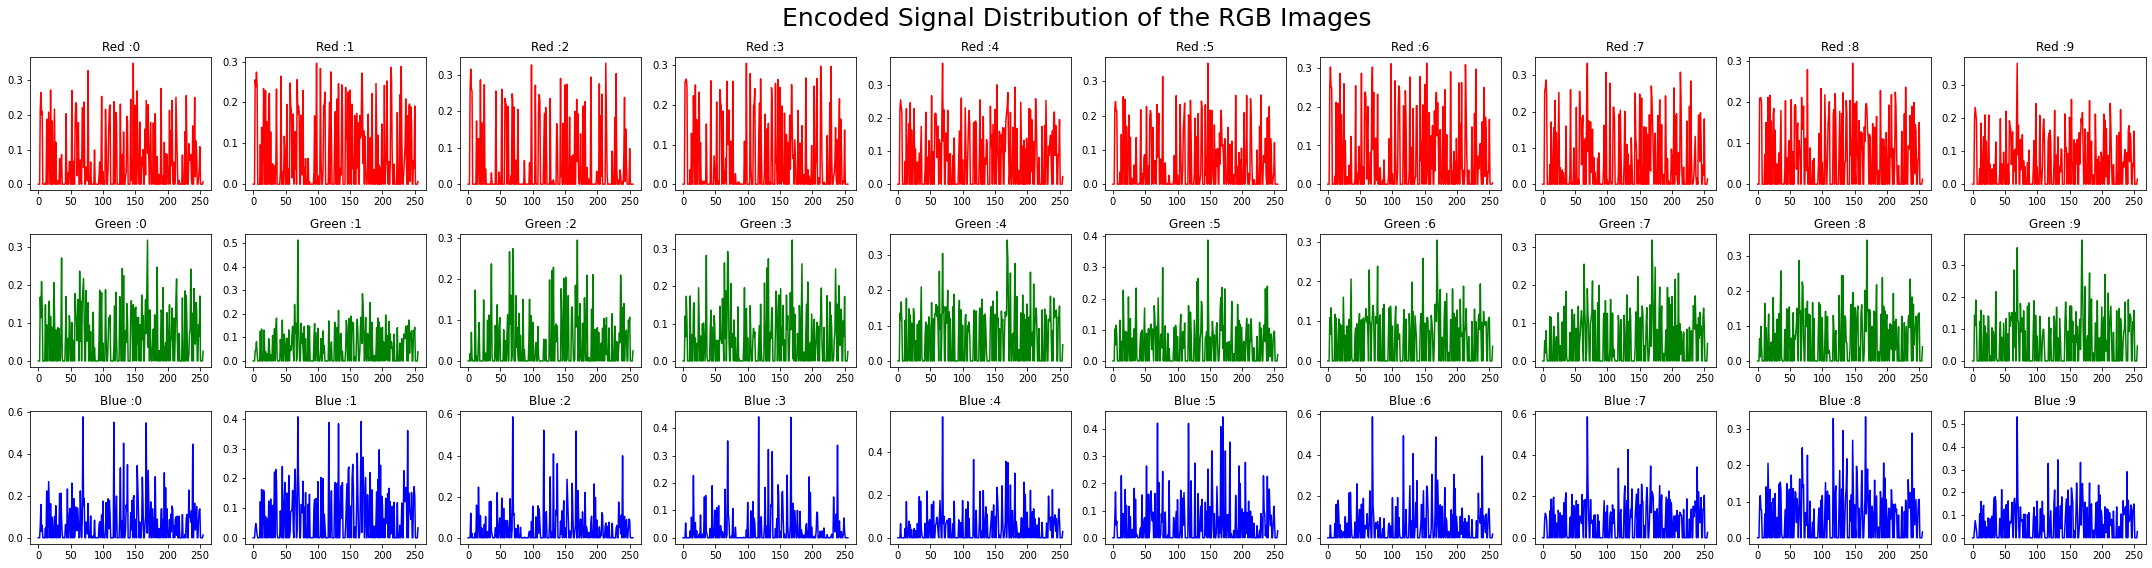

In [183]:
plt.figure(figsize=(30,8))

for i in range(10):
    rindex = labels_30.tolist().index(i)
    gindex = labels_30.tolist().index(i+10)
    bindex = labels_30.tolist().index(i+20)
    plt.subplot(3, 10, i+1)
    plt.plot(outputs[epoch]["encoded"][rindex].detach(), color = 'r')
    plt.title("Red :" +str(i))
    plt.gray()
    plt.subplot(3, 10, i+11)
    plt.plot(outputs[epoch]["encoded"][gindex].detach(), color = 'g')
    plt.title("Green :"+str(i))
    plt.gray()
    plt.subplot(3, 10, i+21)
    plt.plot(outputs[epoch]["encoded"][bindex].detach(), color = 'b')
    plt.title("Blue :"+str(i))
    plt.gray()
    
plt.suptitle("Encoded Signal Distribution of the RGB Images", fontsize =25)
#plt.subplots_adjust(top=1.5)
plt.tight_layout()
plt.show()